# Convolutional Neural Network For Pneumonia diagnosis

*About the dataset*

Chest X-ray images  were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers
import os

print(tf.version.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


# Importing Data

Each image will be resized to 64x64. This is done so our training process takes less time. 

In [2]:
train_dir = 'chest-xray-pneumonia/chest_xray/train'
test_dir =  'chest-xray-pneumonia/chest_xray/test'
X = []
Y = []


for fileName in os.listdir(train_dir + "/NORMAL"): 
        img = cv2.imread(train_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(train_dir + "/PNEUMONIA"): 
        img = cv2.imread(train_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)
            
for fileName in os.listdir(test_dir + "/NORMAL"): 
        img = cv2.imread(test_dir + "/NORMAL/" + fileName)
        if img is not None:
            Y.append(0)
            img = cv2.resize(img,(64,64))
            X.append(img)
    
for fileName in os.listdir(test_dir + "/PNEUMONIA"): 
        img = cv2.imread(test_dir + "/PNEUMONIA/" + fileName)
        if img is not None:
            Y.append(1)
            img = cv2.resize(img,(64,64))
            X.append(img)

Patient with Pneumonia:


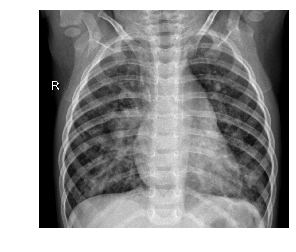

In [3]:
print("Patient with Pneumonia:")
pneumonia = cv2.imread(test_dir + "/PNEUMONIA/person15_virus_46.jpeg")
plt.axis('off')
plt.imshow(pneumonia)

Patient without pneumonia:


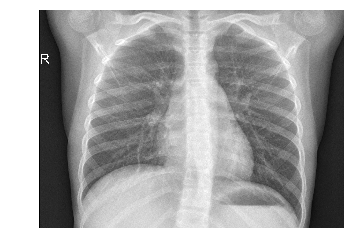

In [4]:
print("Patient without pneumonia:")
normal = cv2.imread(test_dir + "/NORMAL/IM-0003-0001.jpeg")
plt.axis('off')
plt.imshow(normal)

In [5]:
normal.shape

(1509, 2111, 3)

### Problem to solve 

We will train a convolutional neural network to predict the probability of a patient of having pneumonia. Binary cross entropy will be used as our cost function. 

### Data Normalization

Our labels can only take two values: 0 if the patient is not diagnosed with pneumonia, 1 if the patient is diagnosed with pneumonia. This values are loaded as strings so we need to transform them into integers. 
First we need to normalize the data. As pixels in images can only range from 0 to 255 we divide by 255 as it is the maximum value.

We normalize data to avoid gradient divergence or gradient vanishment during the training process. 

In [6]:
X = np.array(X)/255
X = (X - np.average(X,0))/np.std(X,0)

In [7]:
Y = np.array(Y)
Y = Y.astype(int)

### Splitting Data 

We will partition our dataset into training, test and validation datasets. 

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.4)

In [9]:
X_validation, X_test, y_validation, y_test = train_test_split(X_test_validation, y_test_validation,
                                                    stratify=y_test_validation, 
                                                    test_size=0.5)

In [10]:
print("Training set: ", X_train.shape)
print("Test set: ",X_test.shape)
print("Validation set: ",X_validation.shape)

Training set:  (3504, 64, 64, 3)
Test set:  (1168, 64, 64, 3)
Validation set:  (1168, 64, 64, 3)


## Defining the Convolutional Neural Networks

In [16]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]

### Experiment 1:
* input layer with 32 filters of 3x3.
* 2 hidden layers, each with 64 neurons.
* Max pooling between each hidden layer.
* adam optimizer.
* data is fed in a single batch.



### Creating a ModelCheckpoint 

Model checkpoints will be implemented for every experiment. This is done in order to preserve the best performing models and to checkpoint our data to avoid data loss.

* ModelCheckpoint will save the best model based on validation loss while training. 
* EarlyStopping will stop training when validation loss is no longer decreasing

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks_1 = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(('cnn/experiment_1/model.h5'), save_best_only=True, 
                             save_weights_only=False)]

In [18]:
model_1 = tf.keras.Sequential()
model_1.add(layers.Convolution2D(32,(3,3), input_shape=(img_width,img_height,3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))

###classification layer
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [23]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_1.fit(X_train, y_train, epochs=10, callbacks = callbacks_1, validation_data =(X_validation,y_validation))

Train on 3504 samples, validate on 1168 samples
Epoch 1/10
3504/3504 [==============================] - 13s 4ms/sample - loss: 0.2399 - acc: 0.9118 - val_loss: 0.1544 - val_acc: 0.9366
Epoch 2/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.1403 - acc: 0.9515 - val_loss: 0.1845 - val_acc: 0.9469
Epoch 3/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.1267 - acc: 0.9521 - val_loss: 0.1267 - val_acc: 0.9555
Epoch 4/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0976 - acc: 0.9663 - val_loss: 0.1749 - val_acc: 0.9426
Epoch 5/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0858 - acc: 0.9715 - val_loss: 0.1397 - val_acc: 0.9495
Epoch 6/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0555 - acc: 0.9789 - val_loss: 0.1446 - val_acc: 0.9563
Epoch 7/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0575 - acc: 0.9780 - val_loss: 0.1630 - val_acc: 0.9538

In [25]:
score = model_1.evaluate(X_test, y_test)

1168/1168 [==============================] - 1s 621us/sample - loss: 0.1382 - acc: 0.9384


This model performed really well. However, training time took a while. This is due to the fact that a single batch was inserted for each epoch.

### Experiment 2:
* 2 hidden layers, each with 64 neurons.
* Max pooling between each hidden layer.
* adam optimizer.
* data is fed in mini batches of size 32.



In [28]:
model_2 = model_1

In [29]:
callbacks_2 = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(('cnn/experiment_2/model.h5'), save_best_only=True, 
                             save_weights_only=False)]

In [30]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

batch_size = 32
epochs = 10

model_2.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
            callbacks = callbacks_2, validation_data =(X_validation,y_validation))

Train on 3504 samples, validate on 1168 samples
Epoch 1/10
3504/3504 [==============================] - 5s 2ms/sample - loss: 0.0362 - acc: 0.9854 - val_loss: 0.1765 - val_acc: 0.9572
Epoch 2/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0230 - acc: 0.9917 - val_loss: 0.2375 - val_acc: 0.9495
Epoch 3/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0197 - acc: 0.9914 - val_loss: 0.1956 - val_acc: 0.9503
Epoch 4/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0031 - acc: 0.9994 - val_loss: 0.2574 - val_acc: 0.9538
Epoch 5/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0268 - acc: 0.9914 - val_loss: 0.2148 - val_acc: 0.9563
Epoch 6/10
3504/3504 [==============================] - 5s 1ms/sample - loss: 0.0315 - acc: 0.9880 - val_loss: 0.2131 - val_acc: 0.9512


In [31]:
score_2 = model_2.evaluate(X_test, y_test)

1168/1168 [==============================] - 1s 617us/sample - loss: 0.1877 - acc: 0.9521


## Hidden layers as intermediate representations

Working with images is a great opportunity to visualize hidden layers of our convolutional network. These hidden layers represent the feature maps and how the convolutional neural network is training activations and thus decomposing the input images through these filters. 

First we need to define a model that has as output the hidden layers and representations. Then, we will pass an image to the model in order to plot the resulting activations.

In [33]:
layer_outputs = [layer.output for layer in model_2.layers[:8]] 
activation_model = tf.keras.models.Model(inputs=model_2.input, outputs=layer_outputs) 

In [34]:
activation_model

### Make a prediction using the activation model

We will import an image to be used as an example for our activation model layers. 

<img src ="chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person15_virus_46.jpeg" width="400">

In [35]:
image = cv2.imread(test_dir + "/PNEUMONIA/person15_virus_46.jpeg")
image = cv2.resize(image,(64,64))
image = image.reshape(1,64,64,3)

In [36]:
image.shape

(1, 64, 64, 3)

In [37]:
activations = activation_model.predict(image)

In [38]:
first_layer_activation =np.array(activations[0])

In [39]:
first_layer_activation.shape

(1, 62, 62, 32)

C:\Users\jctep\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


IndexError: index 32 is out of bounds for axis 3 with size 32

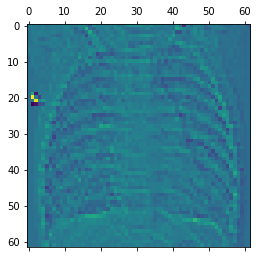

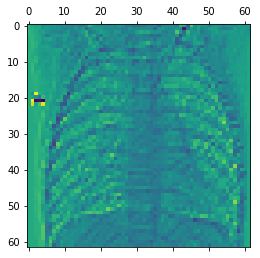

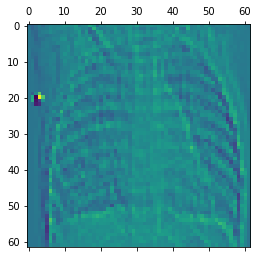

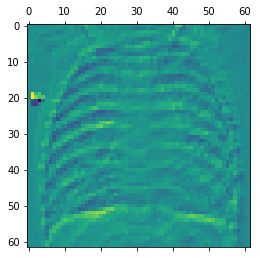

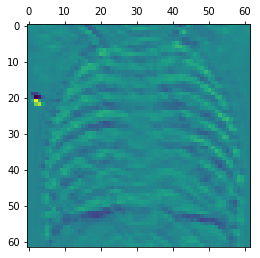

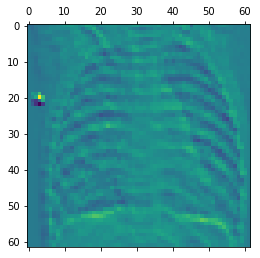

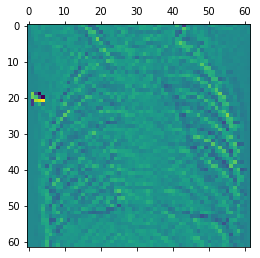

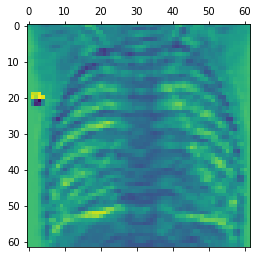

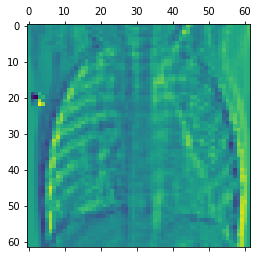

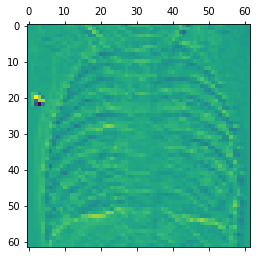

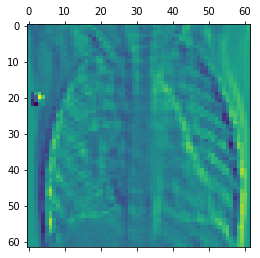

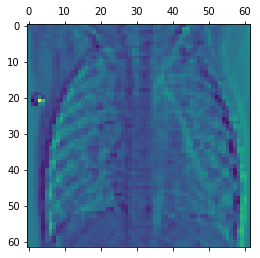

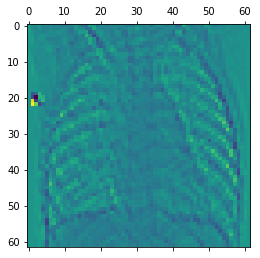

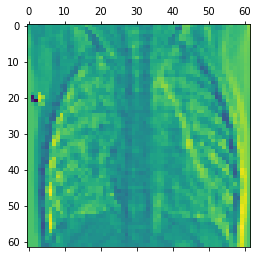

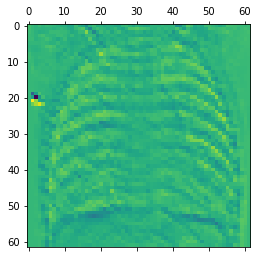

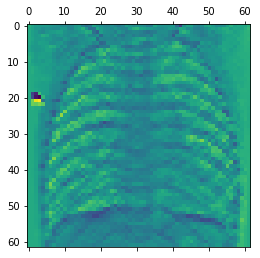

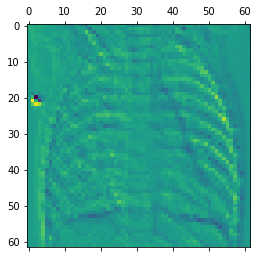

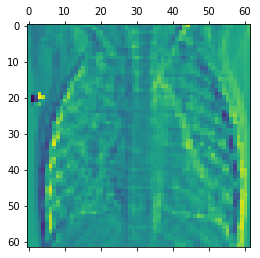

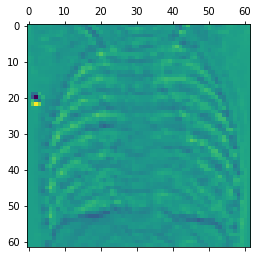

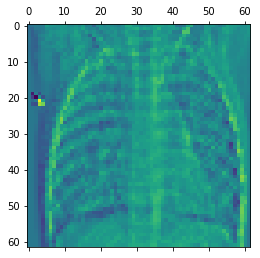

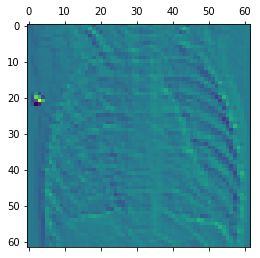

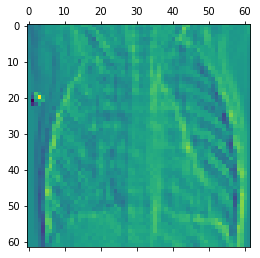

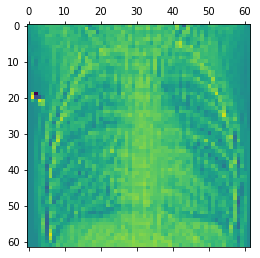

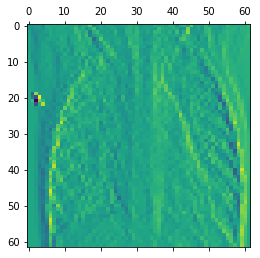

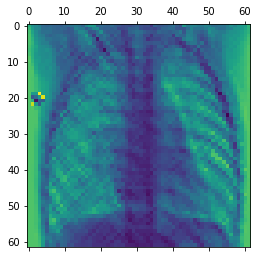

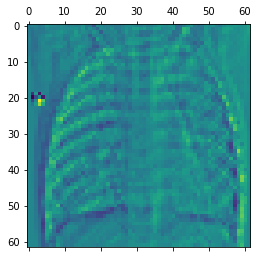

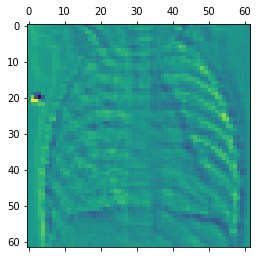

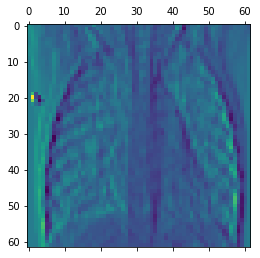

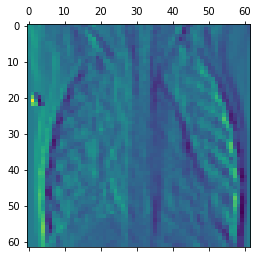

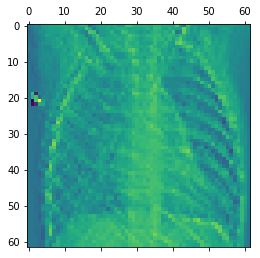

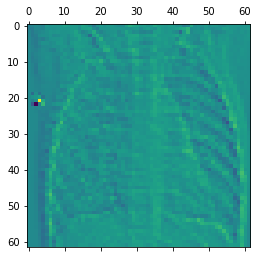

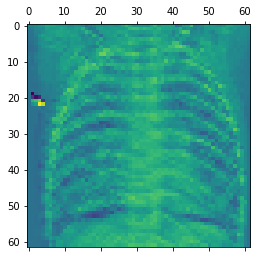

In [41]:
channels = first_layer_activation.shape[1]
i = 0
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1

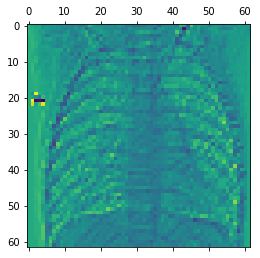

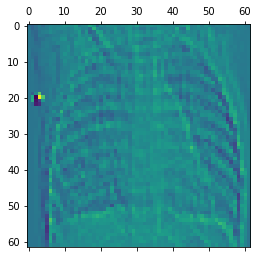

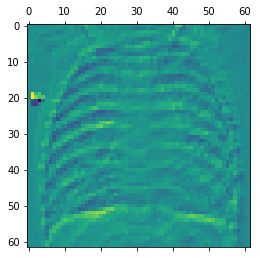

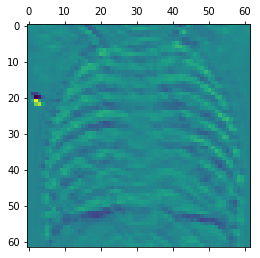

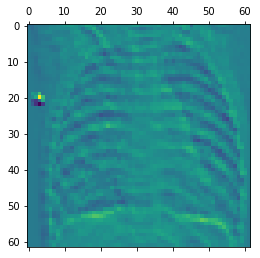

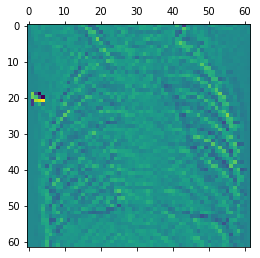

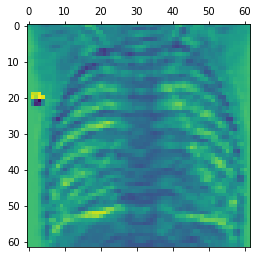

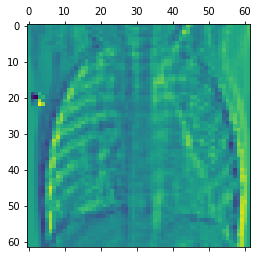

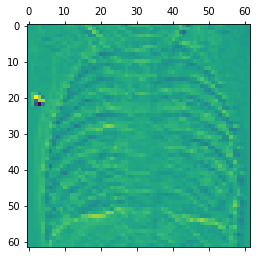

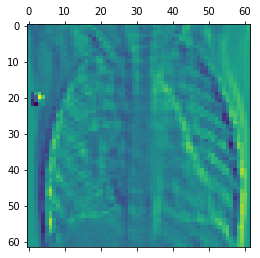

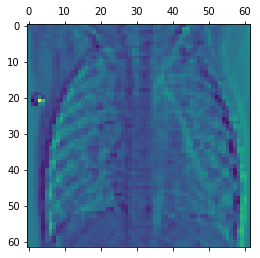

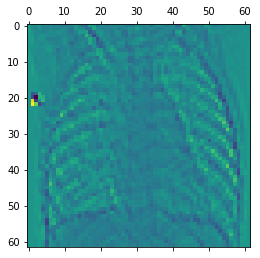

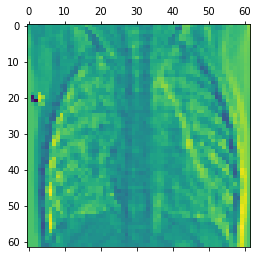

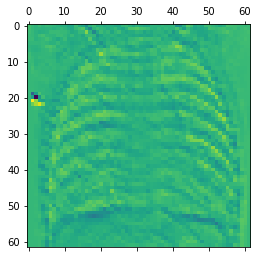

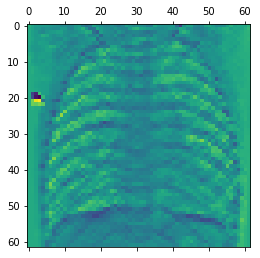

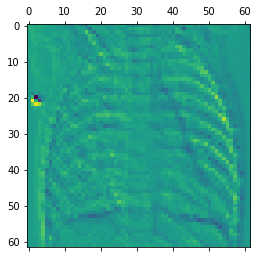

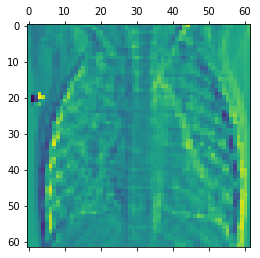

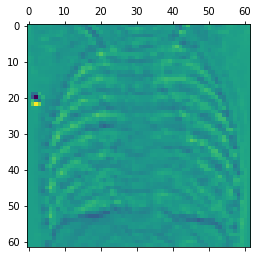

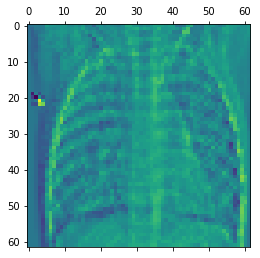

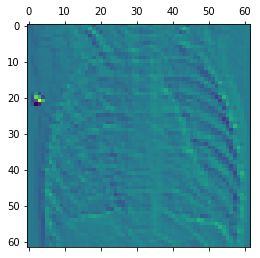

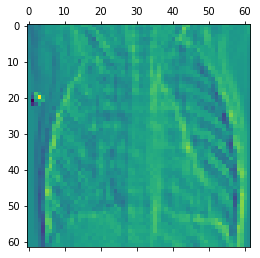

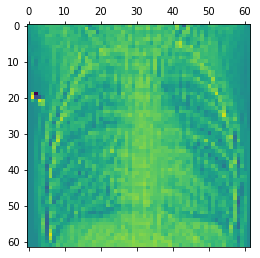

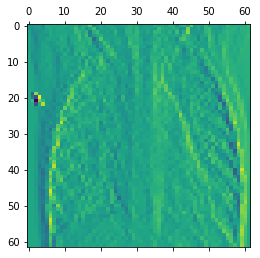

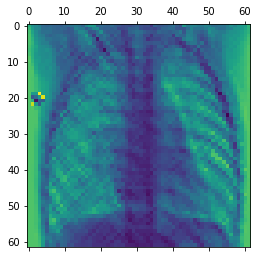

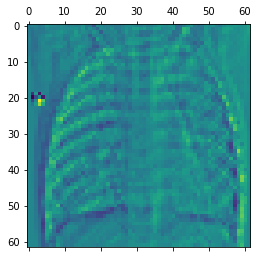

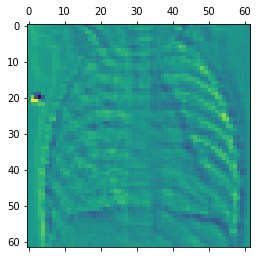

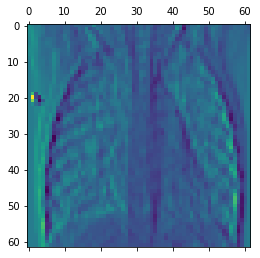

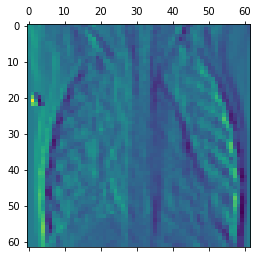

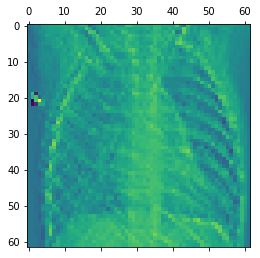

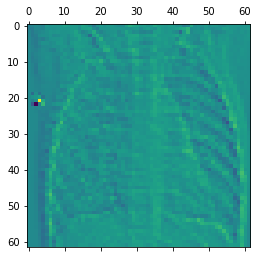

In [45]:
second_layer_activation =np.array(activations[1])
channels = second_layer_activation.shape[1]
i = 1
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1

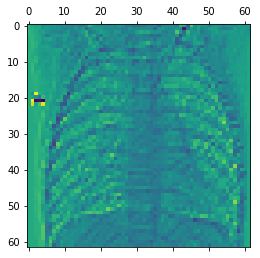

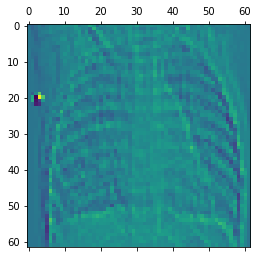

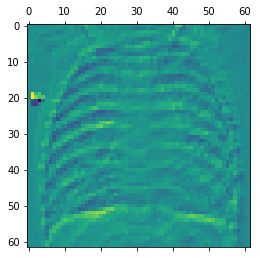

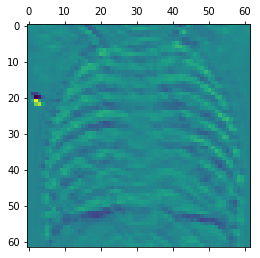

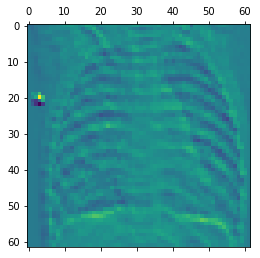

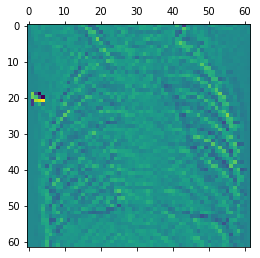

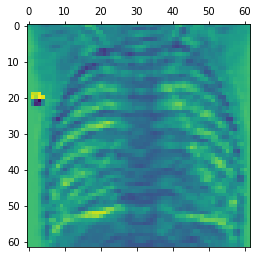

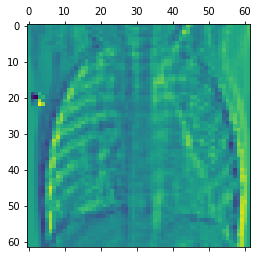

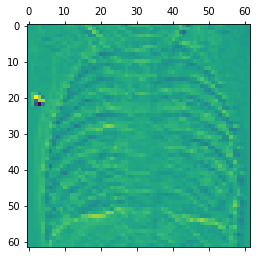

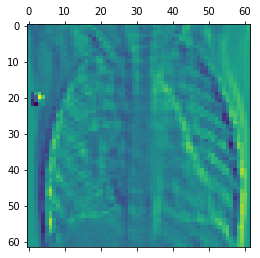

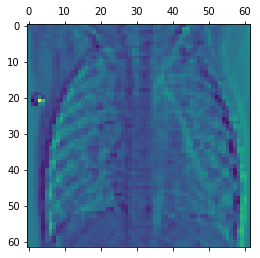

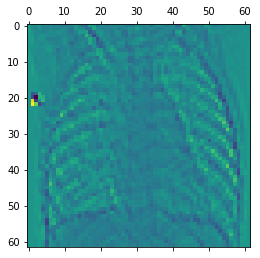

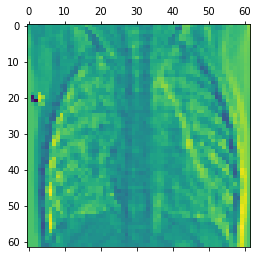

In [49]:
third_layer_activation =np.array(activations[3])
channels = third_layer_activation.shape[1]
i = 1
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1

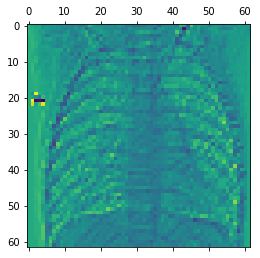

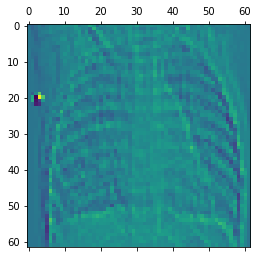

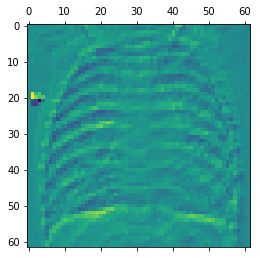

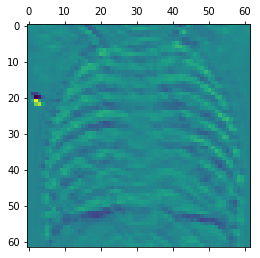

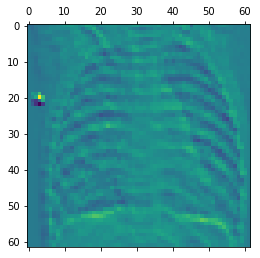

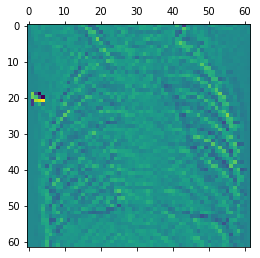

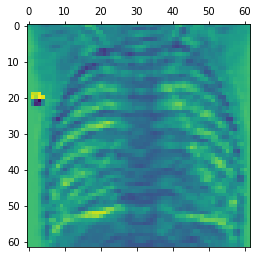

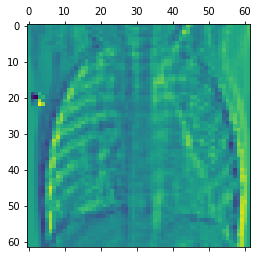

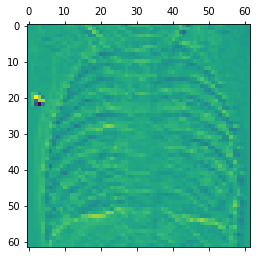

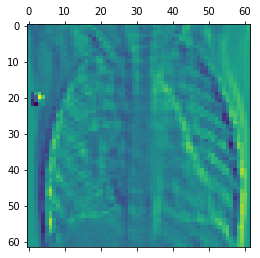

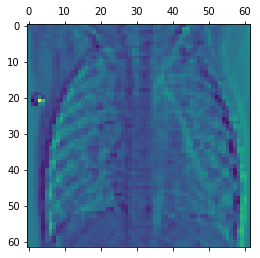

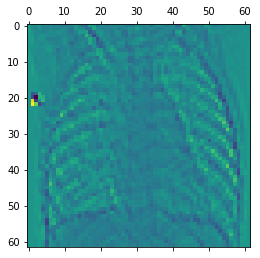

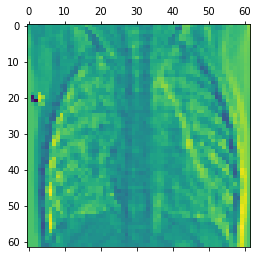

In [51]:
fourth_layer_activation =np.array(activations[3])
channels = fourth_layer_activation.shape[1]
i = 1
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1

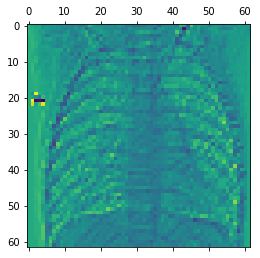

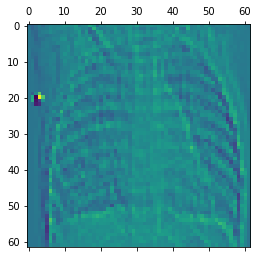

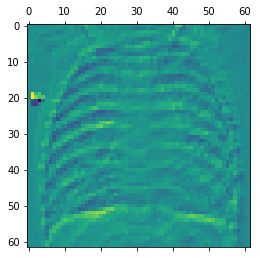

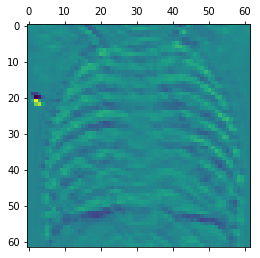

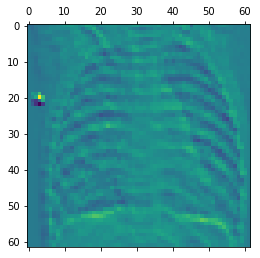

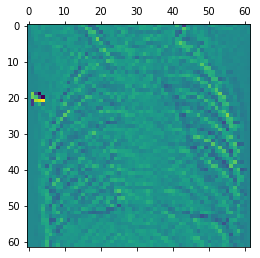

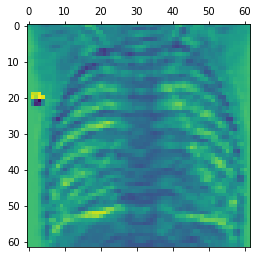

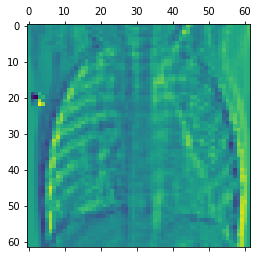

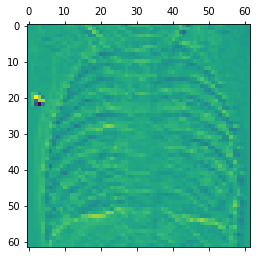

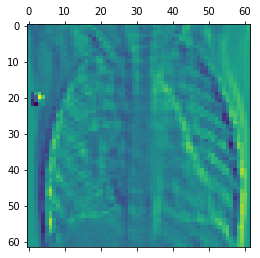

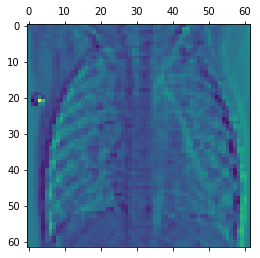

In [55]:
fifth_layer_activation =np.array(activations[4])
channels = fifth_layer_activation.shape[1]
i = 1
while i < channels:
    plt.matshow(first_layer_activation[0, :, :,i], cmap='viridis')
    i+=1